In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
import warnings
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings



df = pd.read_csv('eia_monthly_data.csv')
df['period'] = pd.to_datetime(df['period'])
df.set_index('period', inplace=True)
df.sort_index(inplace=True)

solar_df = df[df['fuelTypeDescription'] == 'solar'].copy()
print("Solar Data Loaded:")
print(solar_df.head())

Solar Data Loaded:
           fueltypeid fuelTypeDescription  consumption-for-eg-btu  \
period                                                              
2001-01-01        SUN               solar                     0.0   
2001-02-01        SUN               solar                     0.0   
2001-03-01        SUN               solar                     0.0   
2001-04-01        SUN               solar                     0.0   
2001-05-01        SUN               solar                     0.0   

            consumption-uto-btu  cost-per-btu  generation  heat-content  \
period                                                                    
2001-01-01                  0.0           NaN         0.0           NaN   
2001-02-01                  0.0           NaN         0.0           NaN   
2001-03-01                  0.0           NaN         0.0           NaN   
2001-04-01                  0.0           NaN         0.0           NaN   
2001-05-01                  0.0           NaN  

In [37]:
solar_capacity = pd.read_excel('eia8602024_1/3_1_Generator_Y2024.xlsx',engine="openpyxl")


In [38]:
new_header = solar_capacity.iloc[0] #grab the first row for the header
solar_capacity_final = solar_capacity[1:] #take the data less the header row
solar_capacity_final.columns = new_header #set the header row as the df header

solar_capacity_final = solar_capacity_final[solar_capacity_final['State'] == 'TX']
solar_capacity_final = solar_capacity_final[solar_capacity_final['Technology']=='Solar Photovoltaic']

solar_capacity_final = solar_capacity_final[['Operating Month', 'Operating Year', 'Nameplate Capacity (MW)']]
solar_capacity_final = solar_capacity_final.groupby(['Operating Year', 'Operating Month'])['Nameplate Capacity (MW)'].sum()


solar_capacity_final.index = pd.to_datetime([f'{m}-01-{y}' for y, m in solar_capacity_final.index])
solar_capacity_df = pd.DataFrame(solar_capacity_final)
solar_capacity_df = solar_capacity_df.sort_index()

solar_capacity_df['cumulative_solar_capacity'] = solar_capacity_df['Nameplate Capacity (MW)'].cumsum()


predictor_series = solar_capacity_df['cumulative_solar_capacity']
# Create a complete monthly date range
full_date_range = pd.date_range(start='2010-11-01', end='2024-12-01', freq='MS')

# Reindex the series to include all months and forward fill missing values
predictor_series = predictor_series.reindex(full_date_range).ffill()

/var/folders/mt/pdjyzsld07d3bsb5b0j5lvp00000gn/T/ipykernel_36733/3030498001.py:24: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [39]:
solar_proposed = pd.read_excel('eia8602024_1/3_1_Generator_Y2024.xlsx', sheet_name='Proposed')


new_header = solar_proposed.iloc[0] #grab the first row for the header
solar_proposed = solar_proposed[1:] #take the data less the header row
solar_proposed.columns = new_header #set the header row as the df header

solar_proposed_final = solar_proposed[solar_proposed['State'] == 'TX']
solar_proposed_final = solar_proposed_final[solar_proposed_final['Technology']=='Solar Photovoltaic']



solar_proposed_final = solar_proposed_final[['Current Month', 'Current Year', 'Nameplate Capacity (MW)']]
solar_proposed_final = solar_proposed_final.groupby(['Current Month', 'Current Year'])['Nameplate Capacity (MW)'].sum()


solar_proposed_final.index = pd.to_datetime([f'{m}-01-{y}' for y, m in solar_proposed_final.index])
solar_proposed_df = pd.DataFrame(solar_proposed_final)

solar_proposed_df = solar_proposed_df.sort_index()
solar_proposed_df['cumulative_solar_capacity'] = solar_proposed_df['Nameplate Capacity (MW)'].cumsum()



In [40]:
solar_proposed_df

,Nameplate Capacity (MW),cumulative_solar_capacity
2025-01-01,635,635
2025-01-02,395.9,1030.9
2025-01-03,400,1430.9
2025-01-04,745,2175.9
2025-01-05,310,2485.9
2025-01-06,744.4,3230.3
2025-01-07,97.0,3327.3
2025-01-08,1804.0,5131.3
2025-01-09,2582.5,7713.8
2025-01-10,1776.2,9490.0


In [41]:
capacity_series = solar_proposed_df['cumulative_solar_capacity']
capacity_series.index = pd.to_datetime(capacity_series.index)

full_idx = pd.date_range('2025-01-01', '2030-06-01', freq='MS')
capacity_series = capacity_series.reindex(full_idx).ffill()



/var/folders/mt/pdjyzsld07d3bsb5b0j5lvp00000gn/T/ipykernel_36733/828008338.py:5: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [42]:
capacity_series

2025-01-01      635.0
2025-02-01      635.0
2025-03-01      635.0
2025-04-01      635.0
2025-05-01      635.0
               ...   
2030-02-01    43504.3
2030-03-01    43504.3
2030-04-01    43504.3
2030-05-01    43504.3
2030-06-01    43504.3
Freq: MS, Name: cumulative_solar_capacity, Length: 66, dtype: float64

In [43]:
predictor_series


2010-11-01       13.9
2010-12-01       13.9
2011-01-01       13.9
2011-02-01       13.9
2011-03-01       13.9
               ...   
2024-08-01    18777.9
2024-09-01    19876.3
2024-10-01    21328.3
2024-11-01    21875.3
2024-12-01    22465.6
Freq: MS, Name: cumulative_solar_capacity, Length: 170, dtype: float64

In [44]:
capacity_series = capacity_series + predictor_series[-1]

/var/folders/mt/pdjyzsld07d3bsb5b0j5lvp00000gn/T/ipykernel_36733/2952279624.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [45]:
solar_capacity = pd.concat([predictor_series, capacity_series])

In [46]:
solar_capacity

2010-11-01       13.9
2010-12-01       13.9
2011-01-01       13.9
2011-02-01       13.9
2011-03-01       13.9
               ...   
2030-02-01    65969.9
2030-03-01    65969.9
2030-04-01    65969.9
2030-05-01    65969.9
2030-06-01    65969.9
Freq: MS, Name: cumulative_solar_capacity, Length: 236, dtype: float64

In [47]:
target_series = solar_df['generation'].dropna()
target_series = target_series[target_series > 0]


In [48]:
def model_sarimax_exog(train_data, exog_train, exog_future, horizon):
    """
    SARIMAX that uses an exogenous variable (predictor).
    """
    # Ensure indices align for safety
    if len(train_data) != len(exog_train):
        raise ValueError("Train data and Exog train data must be same length")
        
    model = SARIMAX(
        train_data,
        exog=exog_train,
        order=(1, 0, 0),              # Adjusted for Solar (Trend usually captured by Exog)
        seasonal_order=(1, 1, 0, 12), # Strong yearly seasonality
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    
    # We must provide the future values of the predictor (exog) to forecast
    forecast = res.get_forecast(steps=horizon, exog=exog_future)
    predicted_mean = forecast.predicted_mean
    
    # Safety Check: If index is not dates, fix it
    if not isinstance(predicted_mean.index, pd.DatetimeIndex):
         last_date = train_data.index[-1]
         forecast_dates = pd.date_range(
            start=last_date + pd.DateOffset(months=1), 
            periods=horizon, 
            freq='MS'
        )
         predicted_mean = pd.Series(predicted_mean.values, index=forecast_dates)
         
    return predicted_mean


In [49]:
def model_sarimax_exog(train_data, exog_train, exog_future, horizon):

    train_data = train_data.astype(float)
    exog_train = exog_train.astype(float)
    exog_future = exog_future.astype(float)

    if len(train_data) != len(exog_train):
        common_idx = train_data.index.intersection(exog_train.index)
        train_data = train_data.loc[common_idx]
        exog_train = exog_train.loc[common_idx]
    
    if train_data.index.freq is None:
        try:
            train_data.index.freq = pd.infer_freq(train_data.index)
            if train_data.index.freq is None:
                train_data = train_data.asfreq('MS')
                exog_train = exog_train.asfreq('MS')
        except:
            pass

    model = SARIMAX(
        train_data,
        exog=exog_train,
        order=(1, 0, 0),              
        seasonal_order=(1, 1, 0, 12), 
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    
    # Forecast
    forecast = res.get_forecast(steps=horizon, exog=exog_future)
    predicted_mean = forecast.predicted_mean
    
    # Ensure index is Datetime
    if not isinstance(predicted_mean.index, pd.DatetimeIndex):
         last_date = train_data.index[-1]
         forecast_dates = pd.date_range(
            start=last_date + pd.DateOffset(months=1), 
            periods=horizon, 
            freq='MS'
        )
         predicted_mean = pd.Series(predicted_mean.values, index=forecast_dates)
         
    return predicted_mean


def run_backtest_with_exog(target_series, predictor_series, model_function, train_window, horizon, step):

    results = []

    aligned_target = target_series
    aligned_predictor = predictor_series
    total_len = len(aligned_predictor)
    
    start_idx = 0
    
    while True:
        end_train_idx = start_idx + train_window
        end_forecast_idx = end_train_idx + horizon
        
        if end_forecast_idx > total_len:
            break
            
        train_target = aligned_target.iloc[start_idx : end_train_idx]
        train_predictor = aligned_predictor.iloc[start_idx : end_train_idx]
        future_predictor = aligned_predictor.iloc[end_train_idx : end_forecast_idx]
        
        try:
            forecast_series = model_function(
                train_target, 
                train_predictor, 
                future_predictor, 
                horizon
            )
            
            results.append({
                'cutoff_date': train_target.index[-1],
                'forecast': forecast_series,
                'actuals': aligned_target # Full aligned actuals for context
            })
            
        except Exception as e:
            print(f"     ! Model failed at {train_target.index[-1]}: {e}")

        # Step
        start_idx += step
        
    return results


def get_prediction_diffs(results_list, sector_name):

    all_dfs = []
    
    if not results_list:
        return None
    
    for res in results_list:
        cutoff = res['cutoff_date']
        fc = res['forecast']
        actuals = res['actuals']
        
        common_idx = fc.index.intersection(actuals.index)
        
        if common_idx.empty:
            continue
            
        diffs = fc[common_idx] - actuals[common_idx]
        
        window_df = pd.DataFrame({
            'Sector': sector_name,
            'Cutoff_Date': cutoff,
            'Prediction_Date': common_idx,
            'Predicted': fc[common_idx],
            'Actual': actuals[common_idx],
            'Error_Diff': diffs,
            'Abs_Error': diffs.abs()
        })
        all_dfs.append(window_df)
            
    return pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()

def evaluate_and_plot(ax, sector_name, results_list):



    full_actuals = results_list[0]['actuals']
    ax.plot(full_actuals.index, full_actuals, color='green', label='Actuals', linewidth=2, zorder=1)
    
    rmse_scores = []
    
    first_fc = True
    for res in results_list:
        fc = res['forecast']
        cutoff = res['cutoff_date']
        
        match_act = res['actuals'].reindex(fc.index)
        valid_idx = match_act.dropna().index
        
        if len(valid_idx) > 0:
            rmse = np.sqrt(mean_squared_error(match_act.loc[valid_idx], fc.loc[valid_idx]))
            rmse_scores.append(rmse)
        
        label = 'Rolling Forecast' if first_fc else None
        ax.plot(fc.index, fc, color='red', linestyle='--', alpha=0.7, label=label, zorder=2)
        ax.scatter(cutoff, full_actuals.get(cutoff), color='black', s=25, zorder=3)
        first_fc = False
    
    avg_rmse = np.mean(rmse_scores) if rmse_scores else 0.0
    
    ax.set_title(f"{sector_name} | Avg RMSE: {avg_rmse:,.0f}")
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    
    return avg_rmse


CHOSEN_MODEL = model_sarimax_exog 
TRAIN_WINDOW = 60
FORECAST_HORIZON = 24
STEP_SIZE = 24

results = run_backtest_with_exog(
    target_series, 
    solar_capacity,
    CHOSEN_MODEL, 
    TRAIN_WINDOW, 
    FORECAST_HORIZON, 
    STEP_SIZE
)


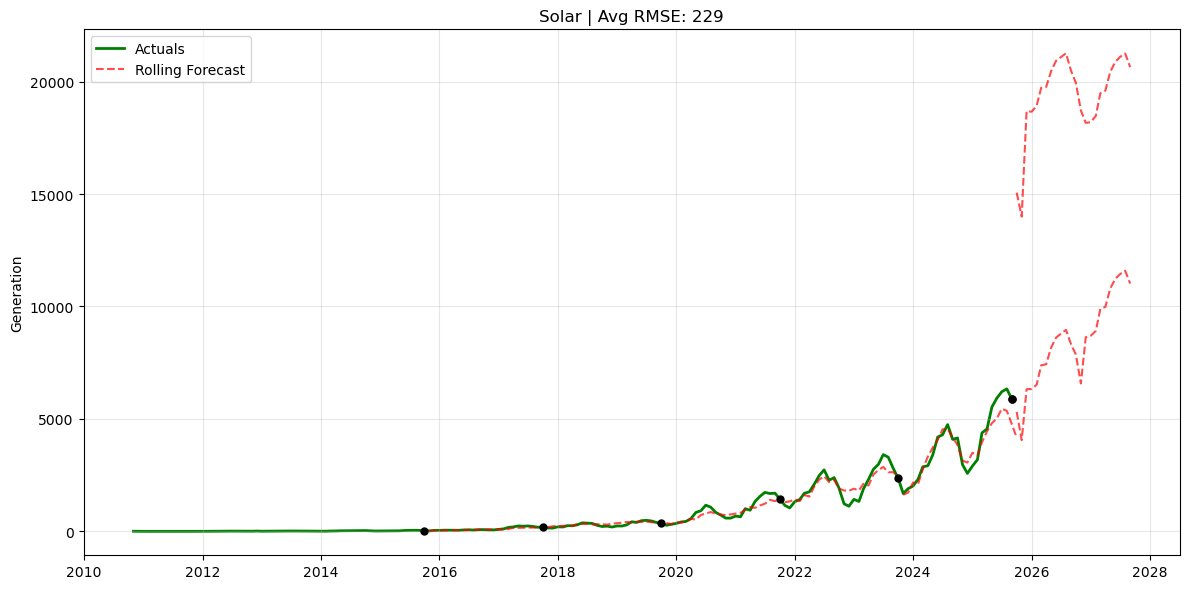


Final Result -> Average RMSE: 229.18

Sample Errors:
  Sector Cutoff_Date Prediction_Date  Predicted    Actual  Error_Diff  \
0  Solar  2015-10-01      2015-11-01  30.444636  22.27509    8.169546   
1  Solar  2015-10-01      2015-12-01  40.948825  45.11093   -4.162105   
2  Solar  2015-10-01      2016-01-01  41.336475  43.73305   -2.396575   
3  Solar  2015-10-01      2016-02-01  40.268298  53.80832  -13.540022   
4  Solar  2015-10-01      2016-03-01  46.828975  51.07700   -4.248025   

   Abs_Error  
0   8.169546  
1   4.162105  
2   2.396575  
3  13.540022  
4   4.248025  


In [50]:

fig, ax = plt.subplots(figsize=(12, 6))
rmse = evaluate_and_plot(ax, 'Solar', results)
ax.set_ylabel("Generation")
plt.tight_layout()
plt.show()

print(f"\nFinal Result -> Average RMSE: {rmse:,.2f}")

# View Errors
all_errors_df = get_prediction_diffs(results, 'Solar')
if not all_errors_df.empty:
    print("\nSample Errors:")
    print(all_errors_df.head())


In [51]:
results[-1]['forecast']

2025-10-01    15059.768790
2025-11-01    14000.187017
2025-12-01    18690.175802
2026-01-01    18661.782416
2026-02-01    18919.526101
2026-03-01    19721.557311
2026-04-01    19764.928724
2026-05-01    20458.579499
2026-06-01    20925.600275
2026-07-01    21089.631432
2026-08-01    21261.498815
2026-09-01    20490.644203
2026-10-01    19942.927087
2026-11-01    18716.187730
2026-12-01    18165.931924
2027-01-01    18197.050373
2027-02-01    18474.688287
2027-03-01    19480.877279
2027-04-01    19597.053835
2027-05-01    20436.752592
2027-06-01    20874.463806
2027-07-01    21101.756662
2027-08-01    21254.327227
2027-09-01    20645.788368
Freq: MS, Name: predicted_mean, dtype: float64

In [52]:
all_errors_df

,Sector,Cutoff_Date,Prediction_Date,Predicted,Actual,Error_Diff,Abs_Error
0,Solar,2015-10-01,2015-11-01,30.444636,22.27509,8.169546,8.169546
1,Solar,2015-10-01,2015-12-01,40.948825,45.11093,-4.162105,4.162105
2,Solar,2015-10-01,2016-01-01,41.336475,43.73305,-2.396575,2.396575
3,Solar,2015-10-01,2016-02-01,40.268298,53.80832,-13.540022,13.540022
4,Solar,2015-10-01,2016-03-01,46.828975,51.07700,-4.248025,4.248025
...,...,...,...,...,...,...,...
114,Solar,2023-10-01,2025-05-01,4813.456880,5527.56180,-714.104920,714.104920
115,Solar,2023-10-01,2025-06-01,5024.416321,5928.92731,-904.510989,904.510989
116,Solar,2023-10-01,2025-07-01,5454.396160,6209.69318,-755.297020,755.297020
117,Solar,2023-10-01,2025-08-01,5359.132813,6337.13296,-978.000147,978.000147


In [53]:
import plotly.graph_objects as go
import pandas as pd

def plot_split_errors_plotly(all_errors_df):
    """
    Generates independent interactive plots showing prediction errors for each forecast run.
    Expects DataFrame cols: ['Sector', 'Cutoff_Date', 'Prediction_Date', 'Error_Diff']
    """
    if all_errors_df.empty:
        print("No error data to plot.")
        return

    # 1. Get list of unique sectors
    sectors = all_errors_df['Sector'].unique()

    print(f"Generating Independent Error Plots for {len(sectors)} sectors...\n")

    for sector in sectors:
        # Filter and Sort by Cutoff Date
        sector_data = all_errors_df[all_errors_df['Sector'] == sector]
        cutoffs = sorted(sector_data['Cutoff_Date'].unique())
        
        if len(cutoffs) == 0:
            continue
            
        print(f"--- Sector: {sector} ({len(cutoffs)} plots) ---")

        # 2. Plot each Cutoff as an Independent Figure
        for i, cutoff in enumerate(cutoffs):
            
            group = sector_data[sector_data['Cutoff_Date'] == cutoff]
            
            # Initialize Independent Figure
            fig = go.Figure()
            
            # Add the Error Line Trace
            fig.add_trace(
                go.Scatter(
                    x=group['Prediction_Date'], 
                    y=group['Error_Diff'],
                    mode='lines+markers',
                    marker=dict(size=6),
                    line=dict(color='#d62728', width=2),
                    name=f"Run {str(cutoff)[:10]}",
                    hovertemplate="<b>Date</b>: %{x}<br><b>Error</b>: %{y:,.2f}<extra></extra>"
                )
            )
            
            # Add Zero Reference Line
            fig.add_hline(
                y=0, 
                line_dash="dash", 
                line_color="black", 
                line_width=1, 
                opacity=0.5
            )

            # Final Layout Adjustments
            cutoff_str = pd.to_datetime(cutoff).strftime('%Y-%m-%d')
            fig.update_layout(
                title_text=f"{sector} Prediction Error | Run: {cutoff_str}",
                title_x=0.5,
                xaxis_title="Prediction Date",
                yaxis_title="Error (Predicted - Actual)",
                template="plotly_white",
                hovermode="x",
                height=400, # Standard height for single plot
                width=1000  # Wide format
            )
            
            fig.show()
        
        print("-" * 80)

In [54]:
plot_split_errors_plotly(all_errors_df)

Generating Independent Error Plots for 1 sectors...

--- Sector: Solar (5 plots) ---


--------------------------------------------------------------------------------


In [55]:
df

,fueltypeid,fuelTypeDescription,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,heat-content-units,receipts-btu,stocks,stocks-units,sulfur-content,total-consumption-btu,year,month
period,,,,,,,,,,,,,,,
2001-01-01,WWW,wood and wood wastes,1.00800,2.49700,NaN,83.43500,NaN,Btu per physical units,0.00000,0.000,thousand physical units,NaN,3.50400,2001,1
2001-01-01,ALL,all fuels,302.33100,36.57100,NaN,31001.28000,7.000,Btu per physical units,184318.67345,14812.817,thousand physical units,0.07,338.90200,2001,1
2001-01-01,COL,"coal, excluding waste coal",121.91700,0.32800,NaN,11683.91100,15.275,Btu per short tons,111849.00240,10421.275,thousand short tons,0.64,122.24500,2001,1
2001-01-01,HYC,conventional hydroelectric,1.42691,0.00000,NaN,138.09300,NaN,Btu per physical units,0.00000,0.000,thousand physical units,NaN,1.42691,2001,1
2001-01-01,NG,natural gas,121.23100,30.15500,NaN,13750.54600,1.026,Btu per Mcf,61879.96194,0.000,thousand Mcf,0.00,151.38500,2001,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-01,WAS,renewable waste products,0.15033,0.16742,NaN,15.61986,0.000,Btu per physical units,NaN,NaN,thousand physical units,NaN,0.31775,2025,9
2025-09-01,WND,wind,25.82718,0.00000,NaN,7569.51448,0.000,Btu per physical units,NaN,NaN,thousand physical units,NaN,25.82718,2025,9
2025-09-01,WWW,wood and wood wastes,0.86133,1.86007,NaN,79.22823,0.000,Btu per physical units,NaN,NaN,thousand physical units,NaN,2.72140,2025,9


In [56]:
all_errors_df

,Sector,Cutoff_Date,Prediction_Date,Predicted,Actual,Error_Diff,Abs_Error
0,Solar,2015-10-01,2015-11-01,30.444636,22.27509,8.169546,8.169546
1,Solar,2015-10-01,2015-12-01,40.948825,45.11093,-4.162105,4.162105
2,Solar,2015-10-01,2016-01-01,41.336475,43.73305,-2.396575,2.396575
3,Solar,2015-10-01,2016-02-01,40.268298,53.80832,-13.540022,13.540022
4,Solar,2015-10-01,2016-03-01,46.828975,51.07700,-4.248025,4.248025
...,...,...,...,...,...,...,...
114,Solar,2023-10-01,2025-05-01,4813.456880,5527.56180,-714.104920,714.104920
115,Solar,2023-10-01,2025-06-01,5024.416321,5928.92731,-904.510989,904.510989
116,Solar,2023-10-01,2025-07-01,5454.396160,6209.69318,-755.297020,755.297020
117,Solar,2023-10-01,2025-08-01,5359.132813,6337.13296,-978.000147,978.000147


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot

def analyze_last_cutoff_residuals(all_errors_df,
                                  sectors_to_plot=None,
                                  eps=1e-9,
                                  max_lag_acf=15):
    """
    all_errors_df: DataFrame with columns
        ['Sector', 'Cutoff_Date', 'Prediction_Date', 'Predicted', 'Actual',
         'Difference' (optional)]
    sectors_to_plot: list of sector names to visualise. If None -> all sectors.
    eps: small constant for MAPE denominator.
    max_lag_acf: number of lags in ACF plot for reference sector.

    All metrics and plots are computed using ONLY rows from the
    last Cutoff_Date PER sector.
    """


    df = all_errors_df.copy()

    # Ensure dates are proper datetimes
    df['Cutoff_Date'] = pd.to_datetime(df['Cutoff_Date'])
    df['Prediction_Date'] = pd.to_datetime(df['Prediction_Date'])
    df['Residual'] = df['Error_Diff']



    last_cutoff_per_sector = df.groupby('Sector')['Cutoff_Date'].transform('max')
    df_last = df[df['Cutoff_Date'] == last_cutoff_per_sector].copy()


    def _sector_metrics(g):
        resid = g['Residual']
        abs_err = resid.abs()
        sq_err = resid.pow(2)

        mask = g['Actual'].abs() > eps

        mae = abs_err.mean()
        rmse = np.sqrt(sq_err.mean())
        bias = resid.mean()
        mape = (abs_err[mask] / g.loc[mask, 'Actual'].abs()).mean() * 100

        return pd.Series({
            "MAE": mae,
            "RMSE": rmse,
            "Bias": bias,
            "MAPE_%": mape
        })

    per_sector_metrics = (
        df_last.groupby('Sector', sort=True)
               .apply(_sector_metrics)
               .sort_index()
    )

    print("Per-sector metrics (last cutoff only):")
    print(per_sector_metrics)




    resid_all = df_last['Residual']
    abs_err_all = resid_all.abs()
    sq_err_all = resid_all.pow(2)
    mask_all = df_last['Actual'].abs() > eps

    global_mae = abs_err_all.mean()
    global_rmse = np.sqrt(sq_err_all.mean())
    global_mape = (abs_err_all[mask_all] /
                   df_last.loc[mask_all, 'Actual'].abs()).mean() * 100

    print("\nGlobal metrics (last cutoff, all sectors stacked):")
    print(f"MAE    : {global_mae:.4f}")
    print(f"RMSE   : {global_rmse:.4f}")
    print(f"MAPE % : {global_mape:.2f}")




    all_sectors = df_last['Sector'].unique()
    if sectors_to_plot is None:
        sectors_to_plot = list(all_sectors)
    else:
        # keep only those present
        sectors_to_plot = [s for s in sectors_to_plot if s in all_sectors]

    if not sectors_to_plot:
        print("\nNo sectors to plot (requested sectors not found in last-cutoff data).")
        return per_sector_metrics



    fig, axes = plt.subplots(len(sectors_to_plot), 1,
                             figsize=(8, 3 * len(sectors_to_plot)))
    if len(sectors_to_plot) == 1:
        axes = [axes]

    for ax, sector in zip(axes, sectors_to_plot):
        g = df_last[df_last['Sector'] == sector]
        ax.hist(g['Residual'].dropna(), bins=30, alpha=0.7)
        ax.set_title(f"Residual histogram – {sector} (last cutoff)")
        ax.set_xlabel("Residual (Pred - Actual)")
        ax.set_ylabel("Frequency")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


    fig, axes = plt.subplots(len(sectors_to_plot), 1,
                             figsize=(6, 4 * len(sectors_to_plot)))
    if len(sectors_to_plot) == 1:
        axes = [axes]

    for ax, sector in zip(axes, sectors_to_plot):
        g = df_last[df_last['Sector'] == sector]
        ax.scatter(g['Actual'], g['Predicted'], alpha=0.4, s=12)
        min_val = min(g['Actual'].min(), g['Predicted'].min())
        max_val = max(g['Actual'].max(), g['Predicted'].max())
        ax.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1)
        ax.set_title(f"Predicted vs Actual – {sector} (last cutoff)")
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

  
    ref_sector = sectors_to_plot[0]
    ref = df_last[df_last['Sector'] == ref_sector].sort_values('Prediction_Date')
    ref_resid = ref.set_index('Prediction_Date')['Residual'].dropna()

    plt.figure(figsize=(8, 4))
    plot_acf(ref_resid, lags=15)
    plt.title(f"ACF of residuals – {ref_sector} (last cutoff)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5, 5))
    qqplot(ref_resid, line="s")
    plt.title(f"QQ plot of residuals – {ref_sector} (last cutoff)")
    plt.tight_layout()
    plt.show()

    return per_sector_metrics

In [58]:
all_errors_df

,Sector,Cutoff_Date,Prediction_Date,Predicted,Actual,Error_Diff,Abs_Error
0,Solar,2015-10-01,2015-11-01,30.444636,22.27509,8.169546,8.169546
1,Solar,2015-10-01,2015-12-01,40.948825,45.11093,-4.162105,4.162105
2,Solar,2015-10-01,2016-01-01,41.336475,43.73305,-2.396575,2.396575
3,Solar,2015-10-01,2016-02-01,40.268298,53.80832,-13.540022,13.540022
4,Solar,2015-10-01,2016-03-01,46.828975,51.07700,-4.248025,4.248025
...,...,...,...,...,...,...,...
114,Solar,2023-10-01,2025-05-01,4813.456880,5527.56180,-714.104920,714.104920
115,Solar,2023-10-01,2025-06-01,5024.416321,5928.92731,-904.510989,904.510989
116,Solar,2023-10-01,2025-07-01,5454.396160,6209.69318,-755.297020,755.297020
117,Solar,2023-10-01,2025-08-01,5359.132813,6337.13296,-978.000147,978.000147


In [59]:
sectors_to_plot = ['solar']

per_sector_metrics =  analyze_last_cutoff_residuals(all_errors_df, sectors_to_plot=sectors_to_plot, eps=1e-9, max_lag_acf=6)

Per-sector metrics (last cutoff only):
               MAE        RMSE        Bias    MAPE_%
Sector                                              
Solar   383.307797  489.602703 -151.218694  9.405245

Global metrics (last cutoff, all sectors stacked):
MAE    : 383.3078
RMSE   : 489.6027
MAPE % : 9.41

No sectors to plot (requested sectors not found in last-cutoff data).


/var/folders/mt/pdjyzsld07d3bsb5b0j5lvp00000gn/T/ipykernel_36733/4281864581.py:59: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

